# Introduction to DiffPrivLib

[DiffPrivLib](https://diffprivlib.readthedocs.io/en/latest/index.html) is a python library dedicated to differential privacy and machine learning. It is based on `scikit-learn` library. 

Some other [introduction notebooks](https://github.com/IBM/differential-privacy-library/tree/main/notebooks) are available directly in the official library repository.

## Step 1: Install the Library

Diffprivlib is available on pypi, it can be installed via the pip command. We will use the latest version of the library to date: version 0.6.6.

In [3]:
!pip install diffprivlib==0.6.6

Defaulting to user installation because normal site-packages is not writeable


## Step 2: Load and Prepare Data

### Load penguin dataset

In this notebook, we will work with the [penguin dataset]("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv") from [seaborn datasets](https://github.com/mwaskom/seaborn-data).
We load the dataset via pandas in a dataframe `df`.

In [1]:
import pandas as pd

In [2]:
path_to_data = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
df = pd.read_csv(path_to_data)

We can look at the first rows of the dataframe to get to know the data:

In [3]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


### Handle null values

DiffPrivLib does not allow null values so we will have to remove or convert them. For simplicity, we will just drop the rows with null values from the dataset.

In [4]:
print(f"{df.shape[0]} rows before dropping nulls")
df = df.dropna()
print(f"{df.shape[0]} rows after dropping nulls")

344 rows before dropping nulls
333 rows after dropping nulls


### Encode columns for Machine Learning

In the following analysis, we will use the `sex` column as a feature column. We encode the `MALE` and `FEMALE` strings in numbers that the models will the able to use.

In [5]:
df["sex"] = df["sex"].map({"MALE": 0, "FEMALE": 1})

In [6]:
df.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1


## Step 3: Logistic Regression with DiffPrivLib

We want to predict penguin's species based on bill length, bill depth, flipper length, body mass and sex. Therefore, we will do a logistic regression.

We first split the data between features and target (to predict).

In [7]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
target_columns = ['species']

In [8]:
feature_data = df[feature_columns]
label_data = df[target_columns]

And then split the data to get a training and a testing set with the [train_test_split function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) from scikit-learn.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
TEST_SIZE = 0.2
RANDOM_STATE = 1 

x_train, x_test, y_train, y_test = train_test_split(
    feature_data,
    label_data,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)
y_train = y_train.to_numpy().ravel()

Then we define the logistic regression pipeline [see doc](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#logistic-regression):

In [11]:
from diffprivlib import models

In [12]:
log_reg = models.LogisticRegression(epsilon = 1.0)

And fit it on the training set:

In [13]:
dpl_pipeline = log_reg.fit(x_train, y_train)

/home/bfs/.local/lib/python3.11/site-packages/diffprivlib/models/logistic_regression.py:231: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "


### Pipeline with logistic regression only (no standard scaler)

We see that we get a `PrivacyLeakWarning` warning because we did not specify the `data_norm` parameter. 

Differential privacy mechanisms need to know how much one individual’s record can change the model. This depends on the sensitivity of the loss function, which in turn depends on the size of feature vectors. `data_norm` is that bound: The maximum L2 norm of any single row (feature vector) in the dataset. 

If it is not specified, DiffPrivLib will infer if from the training data. This may leak information about the dataset (e.g. what the max value was), hence the PrivacyLeakWarning. To avoid that, we should decide on `data_norm` based on domain knowledge before looking at the data.

As common knowledge (without looking at the data), we know that:
- bill length $\in [30.0, 65.0]$,
- bill depth $\in [13.0, 23.0]$,
- flipper length $\in [150.0, 250.0]$,
- body mass $\in [2000.0, 7000.0]$,
- sex $\in [0, 1]$.

Formally, for a row $x = (x_1, \ldots, x_d)$, its L2 norm is $\|x\|_2 = \sqrt{x_1^2 + x_2^2 + \cdots + x_d^2}$.

The ℓ2 norm of a row \(x\) can be bounded using the feature sensitivities:

$$
\|x\|_2 = \sqrt{
(\text{bill length sens})^2 +
(\text{bill depth sens})^2 +
(\text{flipper length sens})^2 +
(\text{body mass sens})^2 +
(\text{sex sens})^2
}
$$

where $sens$, the sensitivity of each feature is defined as $\text{sens} = \text{max} - \text{min}$.

Writing it in a metadata dictionnary, we can then compute the `data_norm`:

In [14]:
import numpy as np

In [15]:
bounds = {
    'bill_length_mm': {'lower': 30.0, 'upper': 65.0},
    'bill_depth_mm': {'lower': 13.0, 'upper': 23.0},
    'flipper_length_mm': {'lower': 150.0, 'upper': 150.0},
    'body_mass_g': {'lower': 2000.0, 'upper': 7000.0},
    'sex': {'lower': 0.0, 'upper': 1.0}, 
}

In [16]:
# TODO: compute the data_norm
#sensitivities = ...
#data_norm = ...

# Correction
sensitivities = [v['upper'] - v['lower'] for v in bounds.values()]
data_norm = np.sqrt(sum(s**2 for s in sensitivities))
print("data_norm =", data_norm)

data_norm = 5000.13259824177


We rewrite the model pipeline with the `data_norm`

In [17]:
log_reg = models.LogisticRegression(epsilon = 1.0, data_norm=data_norm)

Fit it on the training set

In [18]:
log_reg = log_reg.fit(x_train, y_train)

And asses its score (mean accuracy) on the testing set [doc here](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.LogisticRegression.score):

In [19]:
score = log_reg.score(x_test, y_test)
score

0.5970149253731343

### Pipeline with standard scaler before logistic regression

In the previous model, we trained logistic regression without scaling, and we observed that features have very different ranges (e.g., body mass in thousands, sex as 0/1).  
This can cause the optimizer to converge slower, coefficients to be unbalanced, and, in the case of differential privacy, very large row norms that increase the amount of noise added.  

To address this, we will build a pipeline, where we first scale the data with a `StandardScaler` [(doc here)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#standard-scaler) and then fit a logistic regression. Scaling the features puts them on a similar range, improves optimization, and reduces row norms, which leads to better performance and more accurate differentially private estimates.

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
def get_bounds(bounds, columns):
    lower = [bounds[col]["lower"] for col in columns]
    upper = [bounds[col]["upper"] for col in columns]
    return (lower, upper)

In [25]:
dpl_bounds = get_bounds(bounds, columns=feature_columns)
dpl_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 150.0, 7000.0, 1.0])

After scaling with `StandardScaler`, each feature is centered to mean 0 and scaled by its standard deviation. 

Most values are mapped to [-3,3], and thus, the row norm is typically much smaller than in the raw data and can now be bounded more easily.  
We can compute a conservative upper bound for `data_norm` using the bounds of each scaled feature.

In [26]:
n_features = len(feature_columns)
scaled_sensitivities = [6.0] * n_features  # 3 std dev above mean + 3 below
new_data_norm = np.sqrt(sum(s**2 for s in scaled_sensitivities))
print("new_data_norm:", new_data_norm)

new_data_norm: 13.416407864998739


Now fix this pipeline to avoid `PrivacyLeakWarning`

In [27]:
# TODO: Remove the privacy leak warning
#dpl_pipeline_with_scaler = Pipeline([
#    ('scaler', models.StandardScaler(epsilon = 0.5)),
#    ('classifier', models.LogisticRegression(epsilon = 1.0))
#])
#dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)

# Correction
dpl_pipeline_with_scaler = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds)),
    ('classifier', models.LogisticRegression(epsilon = 1.0, data_norm=new_data_norm))
])
dpl_pipeline_with_scaler = dpl_pipeline_with_scaler.fit(x_train, y_train)

And evaluating score of this new model:

In [28]:
# TODO: Evaluate the score of this new pipeline
#sc_score = ...

# Correction
sc_score = dpl_pipeline_with_scaler.score(x_test, y_test)
sc_score

0.40298507462686567

### Estimate spent privacy budget

We can also estimate the budget spent to train the model:

In [29]:
spent_epsilon = 0.0
spent_delta = 0.0
for step in dpl_pipeline_with_scaler.steps:
    spent_epsilon += step[1].accountant.spent_budget[0][0]
    spent_delta += step[1].accountant.spent_budget[0][1]

print(f"The training cost {spent_epsilon} epsilon and {spent_delta} delta.")

The training cost 2.0 epsilon and 0.0 delta.


### Use the model for prediction

We can use the model to predict a species depending on the feature values. 

We try to predict for three cases on female penguins:
- the smallest possible value for all features (lower bound)
- the biggest possible value for all features (upper bound)
- the medium value for all features

In [30]:
x_to_predict_dict = {}
for col in feature_columns:
    lower = bounds[col]['lower']
    upper = bounds[col]['upper']
    midpoint = (lower + upper) / 2
    x_to_predict_dict[col] = [lower, upper, midpoint]

x_to_predict = pd.DataFrame(x_to_predict_dict)
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,30.0,13.0,150.0,2000.0,0.0
1,65.0,23.0,150.0,7000.0,1.0
2,47.5,18.0,150.0,4500.0,0.5


In [31]:
predictions = dpl_pipeline_with_scaler.predict(x_to_predict)
x_to_predict["predictions"] = predictions
x_to_predict

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,30.0,13.0,150.0,2000.0,0.0,Chinstrap
1,65.0,23.0,150.0,7000.0,1.0,Gentoo
2,47.5,18.0,150.0,4500.0,0.5,Gentoo


## Step 4: Clustering KMeans

DiffPrivLib allows to use many other models. We will show here a second example with a K-Means clustering [(see doc)](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#k-means). 

We will do 6 clusters on the features 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g' and 'sex' and see which what cluster emerges. As it is unsupervised learning, there is no target column and we do not do a training and testing set.

In [32]:
N_CLUSTERS = 3

In [33]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
feature_data = df[feature_columns]

In [34]:
dpl_bounds = get_bounds(bounds, columns=feature_columns)
dpl_bounds

([30.0, 13.0, 150.0, 2000.0, 0.0], [65.0, 23.0, 150.0, 7000.0, 1.0])

### StandardScaler and KMeans

In [35]:
kmeans_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds)),
    ('kmeans', models.KMeans(n_clusters = N_CLUSTERS, epsilon = 5.0, bounds=([-3, -3, -3, -3, -3], [3, 3, 3, 3, 3]))),
])

Let's fit the K-Meand model on the clusters

In [36]:
# TODO: Fit the K-Mean pipeline
#kmeans_pipeline = ...

# Correction
kmeans_pipeline = kmeans_pipeline.fit(feature_data)
kmeans_pipeline

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,epsilon,0.5
,bounds,"(array([ 30.,...2000., 0.]), ...)"
,copy,True
,with_mean,True
,with_std,True
,random_state,None
,accountant,"BudgetAccount...0.5, 0), ...])"


We can look at the score of the model, which is the opposite of the value of X on the K-means objective.

In [37]:
kmeans_pipeline.score(feature_data)

-835548.8614589017

And use the model to predict the clusters:

In [38]:
# TODO: Predict clusters on feature_data with K-Mean pipeline
#predictions = ...

# Correction
predictions = kmeans_pipeline.predict(feature_data)

In [39]:
df["predictions"] = predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,2
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,2
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,2
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,2
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,2


We can plot the results to study the clusters

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
def plot_clusters(df, x, y, cluster_col="predictions", style_col="species"):
    """
    Plot two features colored by cluster predictions and shaped by species.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the features, cluster predictions, and species.
    x : str
        Feature name for the x-axis.
    y : str
        Feature name for the y-axis.
    cluster_col : str, default="predictions"
        Column name with cluster assignments.
    style_col : str, default="species"
        Column name for marker style (e.g., species).
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue=cluster_col,
        style=style_col,
        palette="deep",
        s=80
    )
    plt.title(f"DP KMeans Clustering: {x} vs {y}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

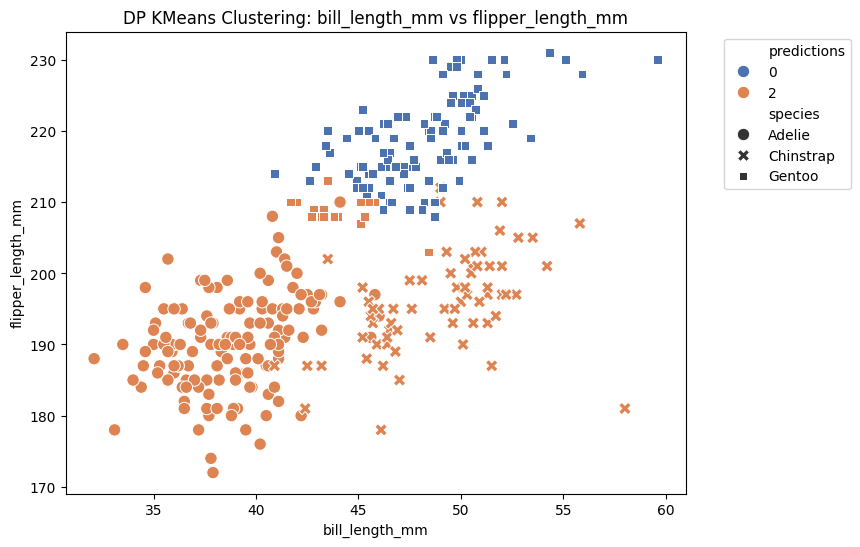

In [42]:
plot_clusters(df, x="bill_length_mm", y="flipper_length_mm")

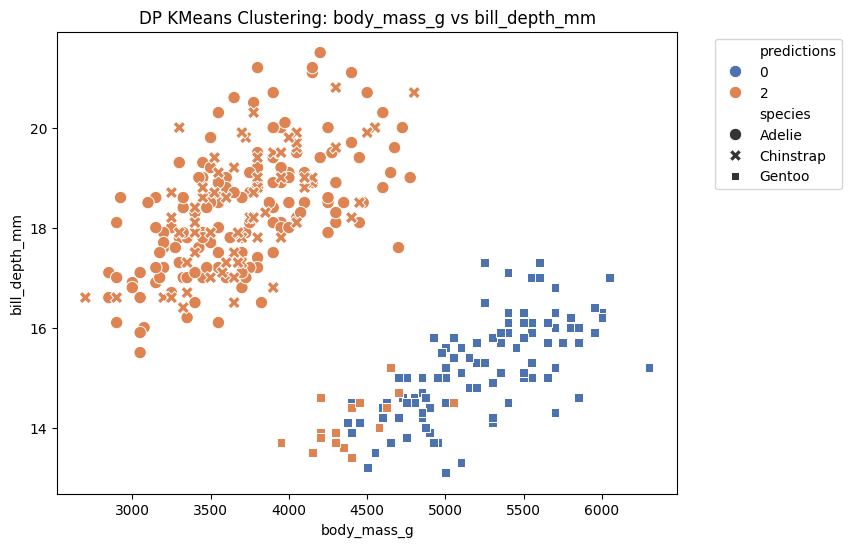

In [43]:
plot_clusters(df, x="body_mass_g", y="bill_depth_mm")

Feel free to try various number of cluster options, feature selection and axis to plot!

### KMeans after PCA and StandardScaler

Let's try do do a dimensionality reduction to two components with a PCA before K-Means to improve the clustering.

In [63]:
N_COMPONENTS = 2

In [60]:
bounds_after_scaler = ([-3]*len(feature_columns), [3]*len(feature_columns))
scaled_sensitivities = [3.0 - (-3.0)] * len(feature_columns)
data_norm_after_scaler = np.sqrt(sum(s**2 for s in scaled_sensitivities))

In [64]:
pca_pipeline = Pipeline([
    ('scaler', models.StandardScaler(epsilon = 0.5, bounds=dpl_bounds)),
    ('pca', models.PCA(n_components=N_COMPONENTS, epsilon=3.0, bounds=bounds_after_scaler, data_norm=data_norm_after_scaler)),
])

We use [fit transform](https://diffprivlib.readthedocs.io/en/latest/modules/models.html#diffprivlib.models.PCA.fit_transform) to fit the model with feature_data and apply directly the dimensionality reduction on it.

In [66]:
pca_feature_data = pca_pipeline.fit_transform(feature_data)
pca_feature_data.shape

(333, 2)

This outputs 2 columns that we add to our dataframe.

In [69]:
df[["pca_1", "pca_2"]] = pd.DataFrame(pca_feature_data, index=df.index)
df.head(1)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,after_pca_predictions,pca_1,pca_2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,2,2,25.174588,-1.330027


We now train a K-Mean clustering on the the principal components:

In [75]:
pca_bounds = ([df["pca_1"].min(), df["pca_2"].min()], [df["pca_1"].max(), df["pca_2"].max()])
kmeans_model = models.KMeans(n_clusters = N_CLUSTERS, epsilon = 2.0, bounds=pca_bounds)

In [77]:
# TODO: fit kmean on principal components
#kmeans_model = ...

# Correction
kmeans_model = kmeans_model.fit(df[["pca_1", "pca_2"]])
kmeans_model

,n_clusters,3
,epsilon,2.0
,bounds,"(array([16.241... -1.71190331]), ...)"
,random_state,None
,accountant,"BudgetAccount...0.5, 0), ...])"


In [79]:
# TODO: Predict clusters on principal compoents with K-Mean pipeline
#predictions = ...

# Correction
after_pca_predictions = kmeans_model.predict(df[["pca_1", "pca_2"]])

In [80]:
df["after_pca_predictions"] = after_pca_predictions
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,predictions,after_pca_predictions,pca_1,pca_2
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,0,2,2,25.174588,-1.330027
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,1,2,2,30.104793,-0.200397
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,1,2,1,39.014293,-0.670145
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,1,2,1,37.207340,-0.627444
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,0,2,1,34.118685,-1.564037


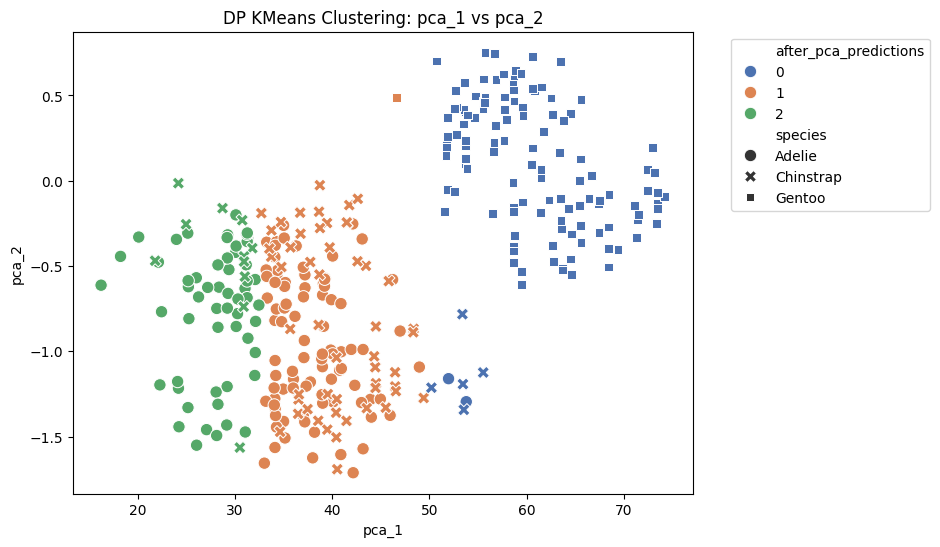

In [82]:
plot_clusters(df, x="pca_1", y="pca_2", cluster_col="after_pca_predictions")

Again, feel free to try various number of principal components, cluster options, feature selection and axis to plot!